In [53]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
import imutils
from tqdm import tqdm
from PIL import Image
from scipy.stats import kurtosis
from skimage import io, filters, measure
import warnings
warnings.filterwarnings("ignore")
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew

# DF of image paths:

In [40]:
# data = 'C:/Users/Lenovo/Documents/MyProjects/Machine learning/Brain Tumor Detection/dataset/Training - Copy'
# No_tumor = 'C:/Users/Lenovo/Documents/MyProjects/Machine learning/Brain Tumor Detection/dataset/Training - Copy/notumor'

# glioma_tumor = 'C:/Users/Lenovo/Documents/MyProjects/Machine learning/Brain Tumor Detection/dataset/Training - Copy/glioma'
# meningioma_tumor = 'C:/Users/Lenovo/Documents/MyProjects/Machine learning/Brain Tumor Detection/dataset/Training - Copy/meningioma'
# pituitary_tumor = 'C:/Users/Lenovo/Documents/MyProjects/Machine learning/Brain Tumor Detection/dataset/Training - Copy/pituitary'

In [41]:
# dirlist=[No_tumor, glioma_tumor, meningioma_tumor, pituitary_tumor]
# classes=['No', 'glioma', 'meningioma', 'pituitary']
# filepaths=[]
# labels=[]
# for i,j in zip(dirlist, classes):
#     filelist=os.listdir(i)
#     for f in filelist:
#         filepath=os.path.join (i,f)
#         filepaths.append(filepath)
#         labels.append(j)
# print ('filepaths:', len(filepaths), '   labels:', len(labels))

# # save the DataFrame as a CSV file
# filepath_df = pd.DataFrame({'filepath':filepaths, 'Label':labels})
# filepath_df
# filepath_df.to_csv('image_paths_after_processing.csv', index=False)

In [42]:
paths = pd.read_csv('image_paths_after_processing.csv')
paths.head()

filepath Label
0  C:/Users/Lenovo/Documents/MyProjects/Machine l...    No
1  C:/Users/Lenovo/Documents/MyProjects/Machine l...    No
2  C:/Users/Lenovo/Documents/MyProjects/Machine l...    No
3  C:/Users/Lenovo/Documents/MyProjects/Machine l...    No
4  C:/Users/Lenovo/Documents/MyProjects/Machine l...    No

In [43]:
paths['Label'].value_counts()

No            1453
pituitary     1327
meningioma    1314
glioma        1123
Name: Label, dtype: int64

### Images df

In [44]:
# rgb_images_array = []
# gray_images_array = []

# for i in paths['filepath']:
#     #reading the image
#     img = imread(i)
#     rgb_images_array.append(img)
#     image = imread(i, cv2.IMREAD_GRAYSCALE)
#     gray_images_array.append(image)

# images_df = pd.DataFrame({'gray_img':gray_images_array, 'rgb_img':rgb_images_array, 'Label':paths['Label']})
# images_df
# images_df.to_csv('image_arr.csv', index=False)

# images = pd.read_csv('image_arr.csv')
# images.head()

## Preprocessing

In [45]:
"""
Finds the extreme points on the image and crops the rectangular out of them
"""
def crop_img(path):
    img = cv2.imread(path)
#     plt.imshow(img)
#     plt.show()
#     print(img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     print(gray.shape)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
#     plt.imshow(new_img)
#     plt.show()
    return new_img


## Image Features

In [50]:
"""
Finds important features extracted from the main image
"""
def image_features(path):
    # image_feature_data = [mean, std, entropy, rms, kurtios, hmi]
    image_feature_data = []
    ########################### First order statical features #############################################
    img = cv2.imread(path)
    # Mean of image
    mean_of_img = np.mean(img)
    image_feature_data.append(mean_of_img)
    
    # Standard deviation of image
    std_of_img = np.std(img)
    image_feature_data.append(std_of_img)
    
    # Vaiance of image
    # Convert the image to a NumPy array
    image_array = np.array(img)
    # Compute the variance of the pixel intensities
    variance = np.var(image_array)
    image_feature_data.append(variance)
    
    # Skewness of image
    # Flatten the array to a 1D array of pixel intensities
    pixel_values = image_array.flatten()
    # Compute the skewness of the pixel intensities
    skewness = skew(pixel_values)
    image_feature_data.append(skewness)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ########################### Enotropy #############################################
    # Compute the histogram of the image
    hist, _ = np.histogram(gray, bins=256, range=(0, 255))
    # Normalize the histogram
    hist = hist / np.sum(hist)
    # Compute the entropy of the image
    entropy = -np.sum(hist * np.log2(hist + 1e-9))
    image_feature_data.append(entropy)
    
    ########################### RMS #############################################
    # Compute the RMS of the image
    rms = np.sqrt(np.mean(np.square(img)))
    image_feature_data.append(rms)
    
    ########################### kurtosis #############################################
    # Calculate the kurtosis of the image
    k = kurtosis(img.flatten())
    image_feature_data.append(k)
    ########################### HMI #############################################
    # Calculate the image moments of the grayscale image
    moments = cv2.moments(gray)
    # Calculate the centroid of the grayscale image
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])
    # Define the radius of the circular mask
    radius = int(min(gray.shape) * 0.4)
    # Create the circular mask
    mask = np.zeros_like(gray)
    cv2.circle(mask, (cx, cy), radius, 255, -1)
    # Apply the mask to the grayscale image
    masked_gray = cv2.bitwise_and(gray, gray, mask=mask)
    # Calculate the Hu moments of the masked grayscale image
    hu_moments = cv2.HuMoments(cv2.moments(masked_gray)).flatten()
    # Normalize the Hu moments
    hu_moments_normalized = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
    # Extract the first four Hu moment invariants
    # (HU1) brightness or intensity of the image
    # (HU2) is related to the symmetry of the image around its vertical axis
    # (HU3) is related to the symmetry of the image around its horizontal axis.
    # (HU4) is related to the skewness of the image, or the degree to which it is asymmetrical.
    hu_invariants = hu_moments_normalized[:4]
    image_feature_data.append(hu_moments_normalized[0])
    image_feature_data.append(hu_moments_normalized[1])
    image_feature_data.append(hu_moments_normalized[2])
    image_feature_data.append(hu_moments_normalized[3])
    return image_feature_data
    
def get_feature(img):
    fet = []
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    distances = [1]  # Specify the pixel distances for the GLCM
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Specify the angles for the GLCM
    glcm = graycomatrix(image_gray, distances, angles, levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    for i in range(len(contrast[0])):
        fet.append(contrast[0][i])
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    for x in range(len(dissimilarity[0])):
        fet.append(dissimilarity[0][x])
    homogeneity = graycoprops(glcm, 'homogeneity')
    for y in range(len(homogeneity[0])):
        fet.append(homogeneity [0][y])
    energy = graycoprops(glcm, 'energy')
    for z in range(len(energy[0])):
        fet.append(energy[0][z])
    correlation = graycoprops(glcm, 'correlation')
    for v in range(len(correlation[0])):
        fet.append(correlation[0][v])
    return fet

# file1 = 'C:/Users/Lenovo/Documents/MyProjects/Machine learning/Brain Tumor Detection/dataset/Training/meningioma/Tr-me_0016.jpg'
# print(image_features(file1)) 
# print(len(image_features(file1)))
# print(get_feature(imread(file1)) 

## Extract Tumor features

In [51]:
"""
1. Finds the contours of the image
2. then extract the tumor contours
3. then extract the mean of area, perimeter, minor ans major axis of contour
"""
# the mean of all tumor contours   
def image_process_tumor_extraction(img):     
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     print(gray_img.shape)
    blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    ret, thres_img = cv2.threshold(blur_img,100,255,cv2.THRESH_BINARY)
#     titles = ['Original Image', 'Gray','Blured', 'Threshold']
#     images_phases = [img, gray_img,blur_img, thres_img ]
#     for i in range(len(images_phases)):
#         plt.subplot(2,2,i+1),plt.imshow(images_phases[i],'gray')
#         plt.title(titles[i])
#         plt.xticks([]),plt.yticks([])
#     plt.show()
    contours, hierarchy = cv2.findContours(thres_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    full_contoured_img = cv2.drawContours(img, contours, -1, (0,255,0), 3)
#     plt.imshow(full_contoured_img)
#     plt.show()
    
    # Select the contour(s) that correspond to the tumor
    tumor_contours = []
    tumor_contour_areas = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000 and area < 50000:
            tumor_contour_areas.append(area)
            tumor_contours.append(contour)
       
    area_of_tumor_contours = []
    perimeter_of_tumor_contours = []
    circulatory_of_tumor_contours = []
    convexity_of_tumor_contours = []
#     fractal_dimension_tumor_contours = []
    solidity_tumor_contours = []
    diameter_tumor_contours = []
    major_axis = []
    minor_axis = []
    eccentricity_tumor_contours = []
    # for extraction of the mean of features of the tumor_contours
    features_tumor_array = [area_of_tumor_contours, perimeter_of_tumor_contours, circulatory_of_tumor_contours, convexity_of_tumor_contours, solidity_tumor_contours, diameter_tumor_contours, major_axis, minor_axis]
#     print(len(features_tumor_array))
    if len(tumor_contours)>0:
        for cnt in tumor_contours:
            ################################ Area Feature  #################################
            area = cv2.contourArea(cnt)
            # print('Area - {}'.format(area))
            area_of_tumor_contours.append(area)
    
            ############################### perimeter Feature ##############################
            perimeter = cv2.arcLength(cnt, True)
            # print('Perimeter - {}'.format(perimeter))
            perimeter_of_tumor_contours.append(perimeter)
    
            ############################### Circle Feature ##############################
            circularity = (4 * np.pi * area) / (perimeter ** 2)
            circulatory_of_tumor_contours.append(circularity)

            ############################### Convexity Feature ##############################
            convex_hull = cv2.convexHull(cnt)
            convexity = cv2.contourArea(convex_hull)
            convexity_of_tumor_contours.append(convexity)

#             ############################### fractal Feature ##############################
#             fractal_dimension = measure.fractal_dimension(contour)
#             fractal_dimension_tumor_contours.append(fractal_dimension)
            
            ############################### solidity Feature ##############################
            if convexity == 0 :
                solidity = 0
            else:
                solidity = float(area)/convexity
            solidity_tumor_contours.append(solidity)

            ############################### Diameter Feature ##############################
            equi_diameter = np.sqrt(4*area/np.pi)
            diameter_tumor_contours.append(equi_diameter)

            ############################### Axis Feature ##############################
            try:
                (x2,y2), (MA,ma), angle = cv2.fitEllipse(cnt)
            except:
                MA = 0
                ma = 0
            major_axis.append(MA)
            minor_axis.append(ma)

#             ############################### Eccentricity Feature ##############################
#             if MA == 0 :
#                 eccentricity = 0
#             else:
#                 # eccentricity = np.sqrt(1-ma**2/MA**2)**(0.5)
#                 eccentricity = np.sqrt(1-(ma/MA)**2)
#             eccentricity_tumor_contours.append(eccentricity)
#             # print('Eccentricity - {}'.format(eccentricity))
    
    features_data = [] 
    if(len(contours) > 0):
        for i in features_tumor_array:
            mean_feature = np.mean(i)
            features_data.append(mean_feature)
        return features_data

    else:
        print('No Tumor Found')
        for i in range(len(features_tumor_array)):
            features_data.append(0)
        return features_data
      
# file1 = 'C:/Users/Lenovo/Documents/MyProjects/Machine learning/Brain Tumor Detection/dataset/Training/meningioma/Tr-me_0016.jpg'
# img = crop_img(paths['filepath'][0])
# print(image_process_tumor_extraction(img))
# print(len(image_process_tumor_extraction(img)))

[10522.7, 1370.4543742179872, 0.10840894004670905, 58857.3, 0.49117423618762873, 94.17757293324973, 148.1402624130249, 261.92918701171874]
8


# Create Features DataFrame

In [54]:
frames = ['Mean', 'std', 'Variance', 'Skewness', 'Entropy', 'RMS', 'Kurtios', 'HMI1', 'HMI2', 'HMI3', 'HMI4','Area','Perimeter', 'Circle','Convex Area','Solidity','Equivalent Diameter','Major Axis','Minor Axis',\
                             'contrast1','contrast2','contrast3','contrast4','dissimilarity1','dissimilarity2','dissimilarity3','dissimilarity4','homogeneity1','homogeneity2','homogeneity3','homogeneity4',\
                             'energy1','energy2','energy3','energy4','correlation1','correlation2','correlation3','correlation4','Class']
data = pd.DataFrame(columns=frames)
# features_tumor_array = [area_of_tumor_contours, perimeter_of_tumor_contours, circulatory_of_tumor_contours,
#                            convexity_of_tumor_contours, fractal_dimension_tumor_contours, solidity_tumor_contours
#                            major_axis, minor_axis, eccentricity_tumor_contours]

for i in range(len(paths['filepath'])):
    if(paths['Label'][i] == 'No'):
        img_path = paths['filepath'][i]
        d = image_features(img_path)
        img = crop_img(img_path)
        tumor_features = image_process_tumor_extraction(img)
        for i in tumor_features:
            d.append(i)
        glcm_features = get_feature(img)
        for x in glcm_features:
            d.append(x)
        d.append(0)
        new_data = pd.DataFrame([d], columns=frames)
        data = data.append(new_data, ignore_index=True)
        
    elif(paths['Label'][i] == 'pituitary'):
        img_path = paths['filepath'][i]
        d = image_features(img_path)
        img = crop_img(img_path)
        tumor_features = image_process_tumor_extraction(img)
        for i in tumor_features:
            d.append(i)
        glcm_features = get_feature(img)
        for x in glcm_features:
            d.append(x)
        d.append(1)
        new_data = pd.DataFrame([d], columns=frames)
        data = data.append(new_data, ignore_index=True)
        
    elif(paths['Label'][i] == 'meningioma'):
        img_path = paths['filepath'][i]
        d = image_features(img_path)
        img = crop_img(img_path)
        tumor_features = image_process_tumor_extraction(img)
        for i in tumor_features:
            d.append(i)
        glcm_features = get_feature(img)
        for x in glcm_features:
            d.append(x)
        d.append(2)
        new_data = pd.DataFrame([d], columns=frames)
        data = data.append(new_data, ignore_index=True)
        
    else:
        img_path = paths['filepath'][i]
        d = image_features(img_path)
        img = crop_img(img_path)
        tumor_features = image_process_tumor_extraction(img)
        for i in tumor_features:
            d.append(i)
        glcm_features = get_feature(img)
        for x in glcm_features:
            d.append(x)
        d.append(3)
        new_data = pd.DataFrame([d], columns=frames)
        data = data.append(new_data, ignore_index=True)

data

Mean        std     Variance  Skewness   Entropy        RMS  \
0     55.212544  46.056565  2121.207208  0.370450  5.375762   9.302612   
1     76.037273  79.565990  6330.746828  0.585233  5.781641   7.635726   
2     53.652053  59.587603  3550.682395  1.574931  4.946379  10.302398   
3     49.231160  42.645217  1818.614523  0.483434  6.123446  10.533521   
4     77.261385  83.705507  7006.611845  0.747321  6.017668   7.935202   
...         ...        ...          ...       ...       ...        ...   
5212  55.537216  41.476325  1720.285572  0.500769  6.681584   9.934108   
5213  58.451622  42.845989  1835.778749  0.488612  6.740698  10.103457   
5214  45.893677  33.173744  1100.497301  0.478187  6.370771   9.474798   
5215  41.703392  36.594254  1339.139410  1.058489  6.356158   9.738114   
5216  36.168495  43.646127  1904.984404  1.089675  5.594215   7.748545   

       Kurtios      HMI1      HMI2       HMI3  ...  homogeneity4   energy1  \
0    -0.628678  2.752905  8.030957  11.070417  ...      0.513325  0.177499   
1    -0.877843  2.904895  7.803627  12.448359  ...      0.432991  0.230150   
2     2.218936  2.779911  7.267831  10.447366  ...      0.490227  0.232071   
3    -1.392569  2.778616  7.928608  10.892414  ...      0.450451  0.374133   
4    -0.774676  2.996775  7.602490  11.633094  ...      0.444437  0.312793   
...        ...       ...       ...        ...  ...           ...       ...   
5212 -0.125073  2.678192  8.030136  10.921777  ...      0.354122  0.149783   
5213 -0.062257  2.700193  8.071390  10.813083  ...      0.334873  0.136611   
5214  0.096858  2.585893  7.683718  10.163987  ...      0.321362  0.081568   
5215  1.184672  2.608306  8.878155  11.275747  ...      0.312610  0.100671   
5216  0.352705  2.614579  7.736397  11.990038  ...      0.403408  0.142878   

       energy2   energy3   energy4  correlation1  correlation2  correlation3  \
0     0.172328  0.180325  0.171641      0.969317      0.959636      0.974818   
1     0.221221  0.232777  0.221043      0.969677      0.958555      0.973180   
2     0.220649  0.233649  0.221646      0.949499      0.932350      0.958399   
3     0.365637  0.379210  0.367641      0.913667      0.891387      0.927097   
4     0.304938  0.317934  0.302303      0.923784      0.898480      0.934894   
...        ...       ...       ...           ...           ...           ...   
5212  0.145493  0.154335  0.144780      0.932639      0.914916      0.949625   
5213  0.132942  0.141475  0.131985      0.936218      0.921140      0.955264   
5214  0.077379  0.082941  0.076869      0.933455      0.915585      0.950032   
5215  0.096011  0.102649  0.095976      0.947402      0.926110      0.953305   
5216  0.135068  0.144641  0.135644      0.957569      0.939330      0.962100   

      correlation4  Class  
0         0.958198      0  
1         0.957760      0  
2         0.931763      0  
3         0.891294      0  
4         0.898350      0  
...            ...    ...  
5212      0.912128      1  
5213      0.920016      1  
5214      0.910542      1  
5215      0.926715      1  
5216      0.941147      1  

[5217 rows x 40 columns]

In [10]:
data.columns

Index(['Mean', 'std', 'Entropy', 'RMS', 'Kurtios', 'HMI1', 'HMI2', 'HMI3',
       'HMI4', 'Area', 'Perimeter', 'Circle', 'Convex Area', 'Solidity',
       'Equivalent Diameter', 'Major Axis', 'Minor Axis', 'Class'],
      dtype='object')

In [ ]:
data = data.drop(data[0])

In [55]:
data.to_csv('var_skew_dataset.csv', index=False) 

In [46]:
data.shape

(5712, 9)

### Canny Edge Datection

In [11]:
# #calculate the edges using Canny edge algorithm
 
# edges_of_image = cv2.Canny(image,100,200) 
 
# #plot the edges
 
# imshow(edges_of_image)

In [124]:
# from skimage.filters.rank import entropy
# from skimage.morphology import disk
# from scipy import ndimage as nd
# from skimage.filters import sobel

# Processing Images & Feature extraction
this part is trials on single images from each class

In [103]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import io, filters, measure

"""
Finds the extreme points on the image and crops the rectangular out of them
"""
def crop_img(path):
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()
#     print(img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     print(gray.shape)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    plt.imshow(new_img)
    plt.show()
    return new_img

def image_process(img):     
#     img = cv2.imread(path)
#     img = cv2.resize(img,(250,250))
#     print(img.shape[2])
#     print(img.shape)
    img_tumor = img.copy()
    img_max = img.copy()
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     print(gray_img.shape)
    blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    ret, thres_img = cv2.threshold(blur_img,100,255,cv2.THRESH_BINARY)
#     ret, thres_img = cv2.threshold(blur_img, 175, 230, 0)
#     ret, thres_img = cv2.threshold(blur_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#     titles = ['Original Image', 'Gray','Blured', 'Threshold']
#     images_phases = [img, gray_img,blur_img, thres_img ]
#     for i in range(len(images_phases)):
#         plt.subplot(2,2,i+1),plt.imshow(images_phases[i],'gray')
#         plt.title(titles[i])
#         plt.xticks([]),plt.yticks([])
#     plt.show()
    contours, hierarchy = cv2.findContours(thres_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    full_contoured_img = cv2.drawContours(img, contours, -1, (0,255,0), 3)
    plt.imshow(full_contoured_img)
    plt.show()
    
    # Select the contour(s) that correspond to the tumor
    tumor_contours = []
    tumor_contour_areas = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000 and area < 50000:
            tumor_contour_areas.append(area)
            tumor_contours.append(contour)
    
#     if (len(tumor_contours) != 0):
#         for tcnt in tumor_contours:
#             min_area_in_tumor = min(tumor_contour_areas)
#             indx = tumor_contour_areas.index(min_area_in_tumor)
#             final_tumor_contour = tumor_contours[indx]
#     tumor_contours = np.array(tumor_contours)
#     indices = []
#     print(len(tumor_contours))
#     for i in range(len(tumor_contours)):
#         # print(tumor_contours[0][1][0][1])
#         if tumor_contours[i][1][0][1] < 60:
#             indices.append(i)
#     if len(indices) != 0:
#         tumor_contours = np.delete(tumor_contours,indices)
#     print(tumor_contours)
    # Draw the selected contour(s) on the original image
    tumor_contoured_img = cv2.drawContours(img_tumor, final_tumor_contour, -1, (255, 0, 0), 2)
    plt.imshow(tumor_contoured_img)
    plt.show()
     
    features_data = [] 
    if len(contours)>0:
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        max_contour_img = cv2.drawContours(img_max, cnt, -1, (0, 0, 255), 2)
        plt.imshow(max_contour_img)
        plt.show()
        
        
        #print('Contours - {}'.format(len(contours)))
            
        x, y, w, h = cv2.boundingRect(cnt)
        r = cv2.rectangle(gray_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        #plt.imshow(r)
        
        area = cv2.contourArea(cnt)
        features_data.append(area)
#         print('Area - {}'.format(area))
        
        (x1, y1), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x1), int(y1))
        radius = int(radius)
        c = cv2.circle(gray_img, center, radius, (255, 0, 0), 2)
        #plt.imshow(c)
        
        perimeter = cv2.arcLength(cnt, True)
        features_data.append(perimeter)
#         print('Perimeter - {}'.format(perimeter))
        
        #aspect_ratio = float(w)/h
        #print('Aspect Ratio - {}'.format(aspect_ratio))
        
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        features_data.append(hull_area)
#         print('Convex Area - {}'.format(hull_area))
        if hull_area == 0 :
            solidity = 0
        else:
            solidity = float(area)/hull_area
        features_data.append(solidity)
#         print('Solidity - {}'.format(solidity))
        
        equi_diameter = np.sqrt(4*area/np.pi)
        features_data.append(equi_diameter)
#         print('Equivalent Diameter - {}'.format(equi_diameter))
        
        try:
            (x2,y2), (MA,ma), angle = cv2.fitEllipse(cnt)
        except:
            MA = 0
            ma = 0
        features_data.append(MA)
        features_data.append(ma)
        print('MA - {}'.format(MA))
#         print('Major Axis - {}'.format(MA))
#         print('Minor Axis - {}'.format(ma))
        
        #eccentricity = np.sqrt(1-(ma/MA)**2)
        if MA == 0 :
            eccentricity = 0
        else:
            eccentricity = (1-ma**2/MA**2)**(0.5)
        features_data.append(eccentricity)
#         print('Eccentricity - {}'.format(eccentricity))
                           
        return features_data
        
    else:
                
        print('No Tumor Found')
        for i in range(8):
            features_data.append(0)
        return features_data
    
    
# the mean of all tumor contours   
def image_process_tumor_extraction(img):     
#     img = cv2.imread(path)
#     img = cv2.resize(img,(250,250))
#     print(img.shape[2])
#     print(img.shape)
    img_tumor = img.copy()
    img_max = img.copy()
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     print(gray_img.shape)
    blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    ret, thres_img = cv2.threshold(blur_img,100,255,cv2.THRESH_BINARY)
#     ret, thres_img = cv2.threshold(blur_img, 175, 230, 0)
#     ret, thres_img = cv2.threshold(blur_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#     titles = ['Original Image', 'Gray','Blured', 'Threshold']
#     images_phases = [img, gray_img,blur_img, thres_img ]
#     for i in range(len(images_phases)):
#         plt.subplot(2,2,i+1),plt.imshow(images_phases[i],'gray')
#         plt.title(titles[i])
#         plt.xticks([]),plt.yticks([])
#     plt.show()
    contours, hierarchy = cv2.findContours(thres_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    full_contoured_img = cv2.drawContours(img, contours, -1, (0,255,0), 3)
    plt.imshow(full_contoured_img)
    plt.show()
    
    # Select the contour(s) that correspond to the tumor
    tumor_contours = []
    tumor_contour_areas = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000 and area < 50000:
            tumor_contour_areas.append(area)
            tumor_contours.append(contour)
    
#     if (len(tumor_contours) != 0):
#         for tcnt in tumor_contours:
#             min_area_in_tumor = min(tumor_contour_areas)
#             indx = tumor_contour_areas.index(min_area_in_tumor)
#             final_tumor_contour = tumor_contours[indx]
#     tumor_contours = np.array(tumor_contours)
#     indices = []
#     print(len(tumor_contours))
#     for i in range(len(tumor_contours)):
#         # print(tumor_contours[0][1][0][1])
#         if tumor_contours[i][1][0][1] < 60:
#             indices.append(i)
#     if len(indices) != 0:
#         tumor_contours = np.delete(tumor_contours,indices)
#     print(tumor_contours)
    # Draw the selected contour(s) on the original image
    tumor_contoured_img = cv2.drawContours(img_tumor, final_tumor_contour, -1, (255, 0, 0), 2)
    plt.imshow(tumor_contoured_img)
    plt.show()
     
    
    area_of_tumor_contours = []
    perimeter_of_tumor_contours = []
    circulatory_of_tumor_contours = []
    convexity_of_tumor_contours = []
    fractal_dimension_tumor_contours = []
    solidity_tumor_contours = []
    major_axis = []
    minor_axis = []
    eccentricity_tumor_contours = []
    # for extraction of the mean of features of the tumor_contours
    features_tumor_array = [area_of_tumor_contours, perimeter_of_tumor_contours, circulatory_of_tumor_contours,
                           convexity_of_tumor_contours, fractal_dimension_tumor_contours, solidity_tumor_contours
                           major_axis, minor_axis, eccentricity_tumor_contours]
    if len(tumor_contours)>0:
        for cnt in tumor_contours:
            ################################ Area Feature  #################################
            area = cv2.contourArea(cnt)
            # print('Area - {}'.format(area))
            area_of_tumor_contours.append(area)
    
            ############################### perimeter Feature ##############################
            perimeter = cv2.arcLength(cnt, True)
            # print('Perimeter - {}'.format(perimeter))
            perimeter_of_tumor_contours.append(perimeter)
    
            ############################### Circle Feature ##############################
            circularity = (4 * np.pi * area) / (perimeter ** 2)
            circulatory_of_tumor_contours.append(circularity)

            ############################### Convexity Feature ##############################
            convex_hull = cv2.convexHull(cnt)
            convexity = cv2.contourArea(hull)
            convexity_of_tumor_contours.append(convexity)

            ############################### fractal Feature ##############################
            fractal_dimension = measure.fractal_dimension(contour)
            fractal_dimension_tumor_contours.append(fractal_dimension)
            
            ############################### solidity Feature ##############################
            if convexity == 0 :
                solidity = 0
            else:
                solidity = float(area)/convexity
            solidity_tumor_contours.append(solidity)

            ############################### Diameter Feature ##############################
            equi_diameter = np.sqrt(4*area/np.pi)
            diameter_tumor_contours.append(equi_diameter)

            ############################### Axis Feature ##############################
            try:
                (x2,y2), (MA,ma), angle = cv2.fitEllipse(cnt)
            except:
                MA = 0
                ma = 0
            major_axis.append(MA)
            minor_axis.append(ma)

            ############################### Eccentricity Feature ##############################
            if MA == 0 :
                eccentricity = 0
            else:
                # eccentricity = np.sqrt(1-ma**2/MA**2)**(0.5)
                eccentricity = np.sqrt(1-(ma/MA)**2)
            eccentricity_tumor_contours.append(eccentricity)
            # print('Eccentricity - {}'.format(eccentricity))
    
    features_data = [] 
    if(len(contours) > 0):
        for i in features_tumor_array:
            mean_feature = np.mean(i)
            features_data.append(mean_feature)
        return features_data

    else:
        print('No Tumor Found')
        for i in range(len(features_tumor_array)):
            features_data.append(0)
        return features_data


In [104]:
file1 = 'C:/Users/Lenovo/Documents/MyProjects/Machine learning/Brain Tumor Detection/dataset/Training/glioma/Tr-gl_0020.jpg'
file2 = 'C:/Users/Lenovo/Documents/MyProjects/Machine learning/Brain Tumor Detection/dataset/Training/meningioma/Tr-me_0016.jpg'
file3 = 'C:/Users/Lenovo/Documents/MyProjects/Machine learning/Brain Tumor Detection/dataset/Training/notumor/Tr-no_0018.jpg'
file4 = 'C:/Users/Lenovo/Documents/MyProjects/Machine learning/Brain Tumor Detection/dataset/Training/pituitary/Tr-pi_0029.jpg'
# manual cropped
file = 'C:/Users/Lenovo/Documents/GitHub/Brain-Tumor-Datection/processed images/1.PNG'
crop_file = 'C:/Users/Lenovo/Documents/GitHub/Brain-Tumor-Datection/processed images/2.PNG'

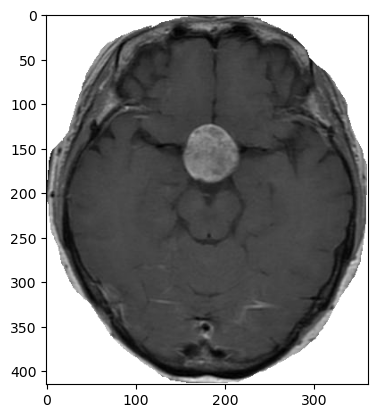

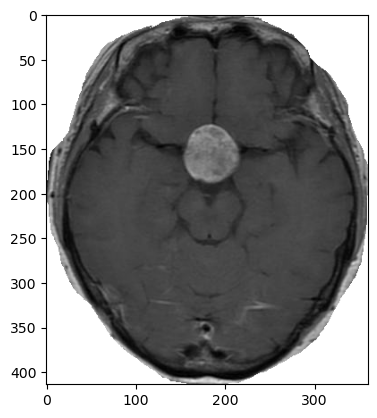

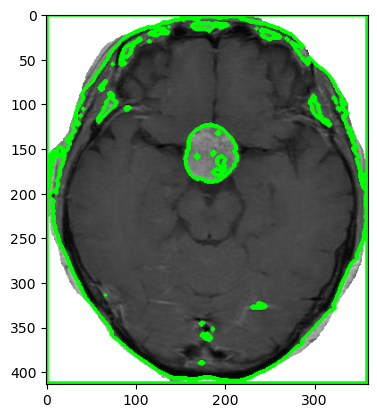

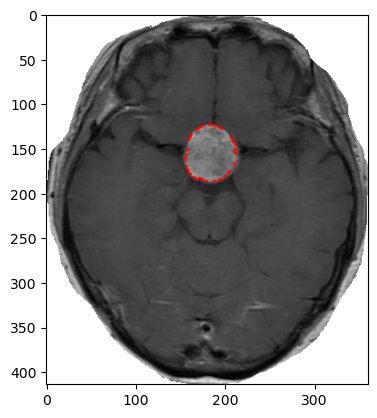

In [105]:
img = crop_img(file)

image_process(img)

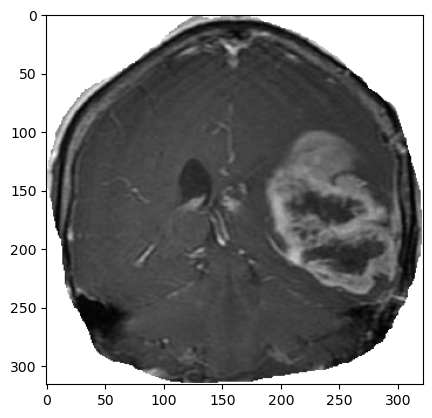

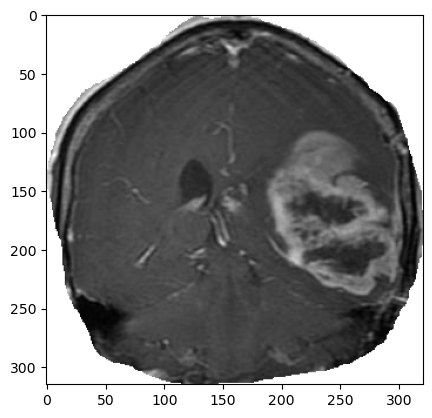

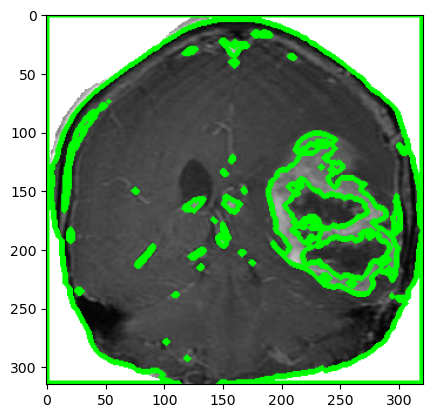

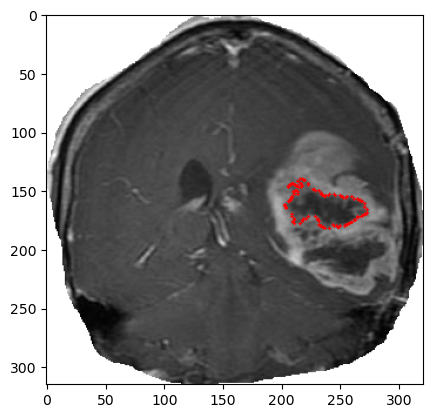

In [106]:
img = crop_img(crop_file)

image_process(img)

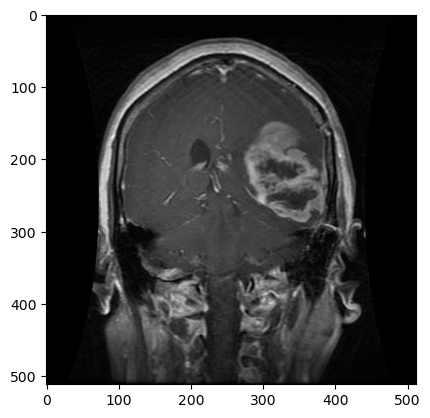

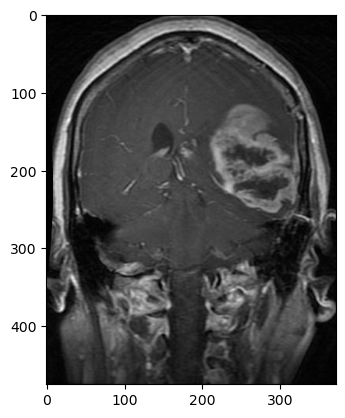

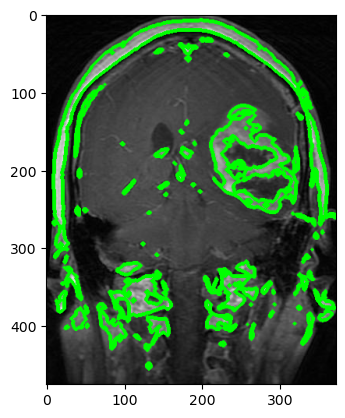

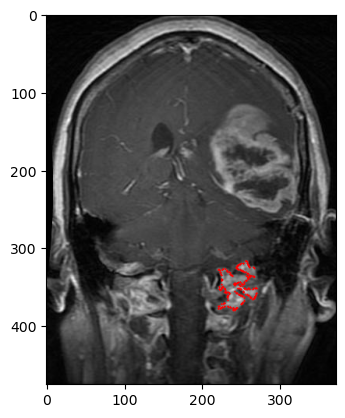

In [107]:
img = crop_img(file1)
image_process(img)



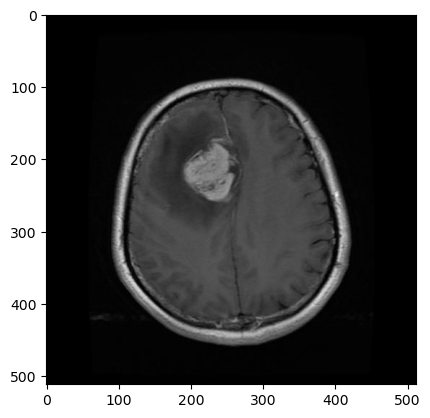

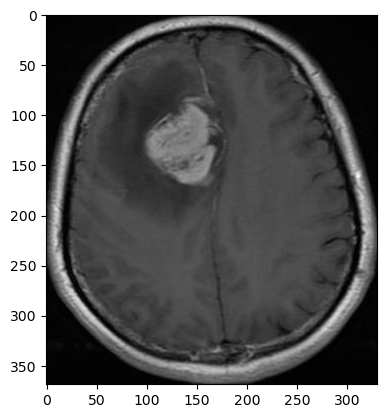

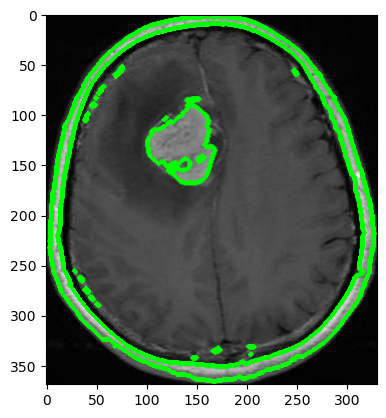

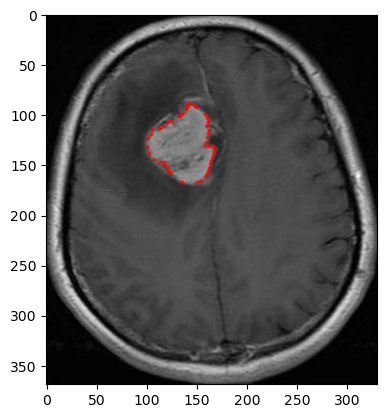

In [108]:
img = crop_img(file2)
image_process(img)

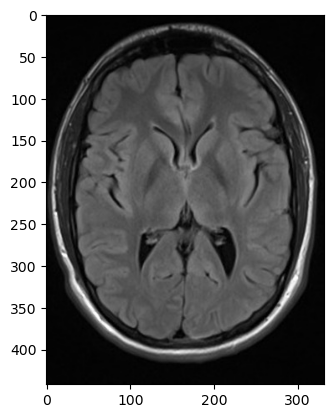

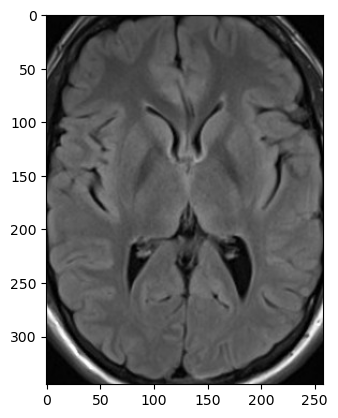

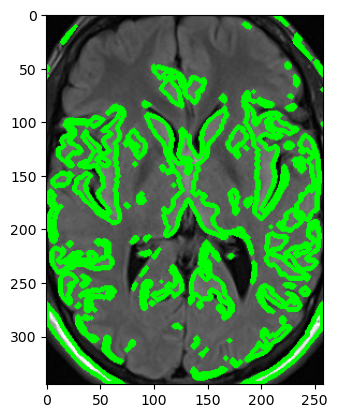

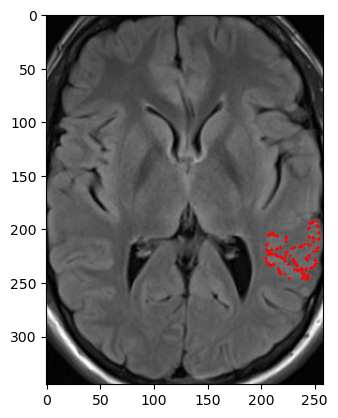

In [109]:
img = crop_img(file3)
image_process(img)

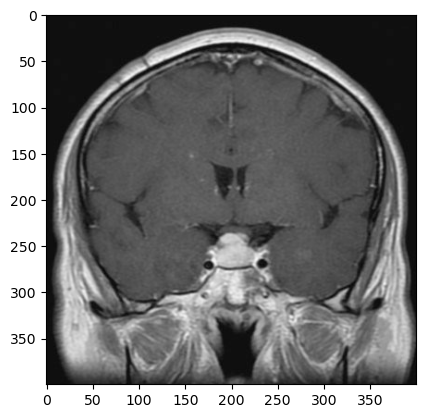

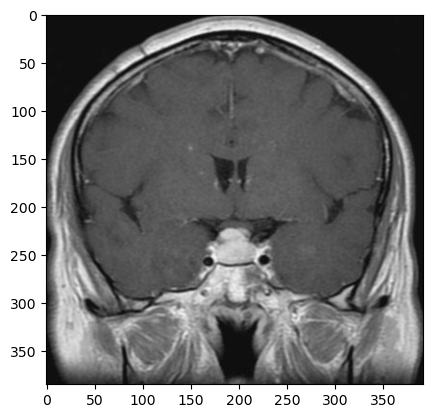

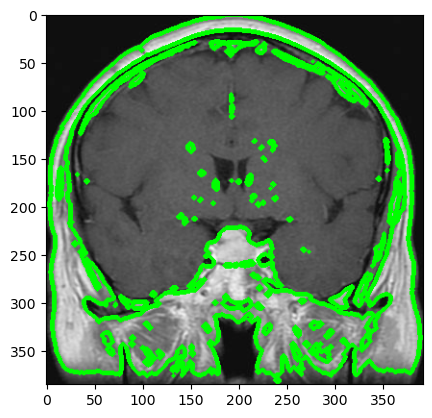

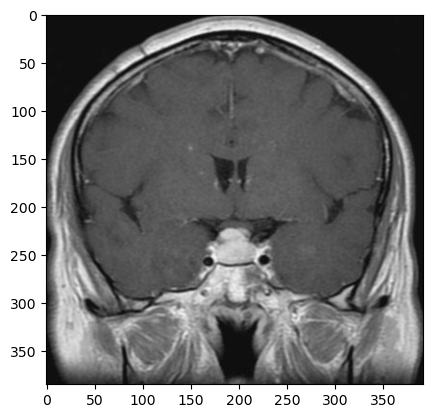

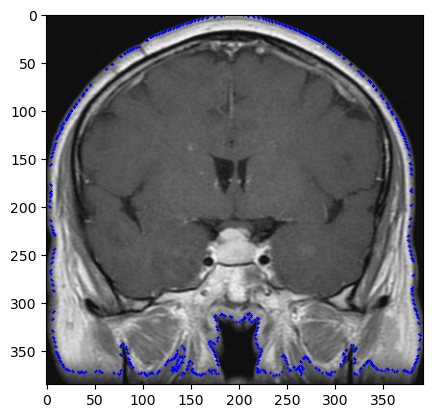

In [95]:
img = crop_img(file4)
image_process(img)

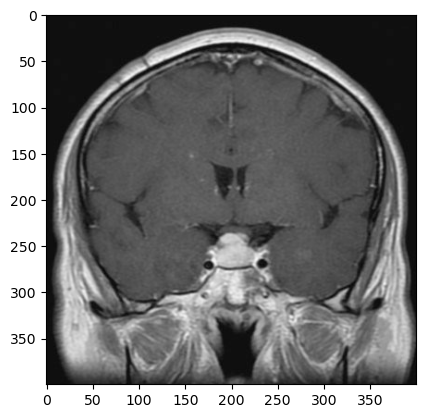

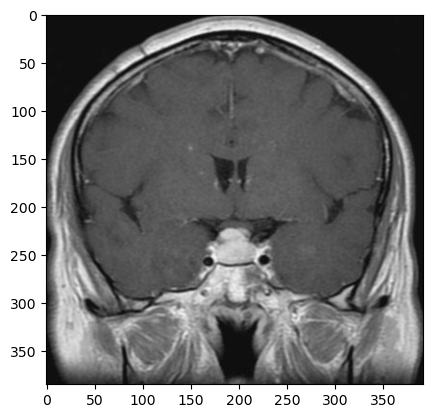

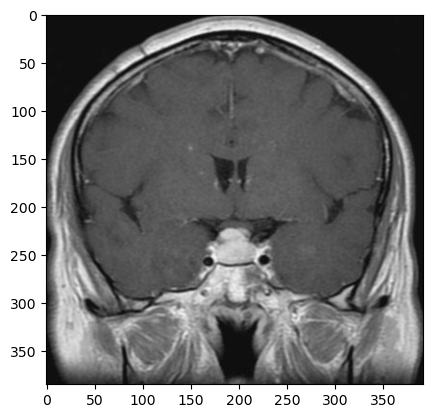

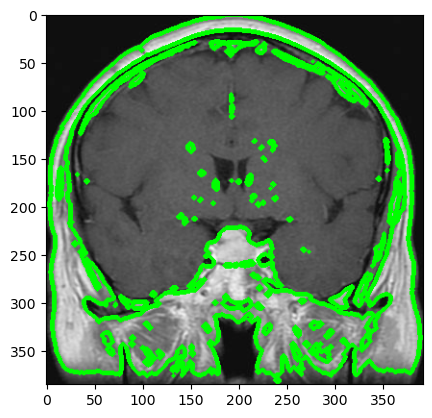

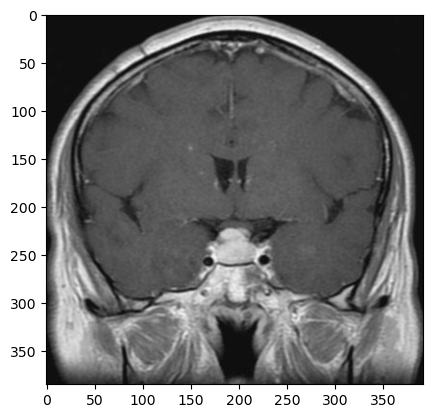

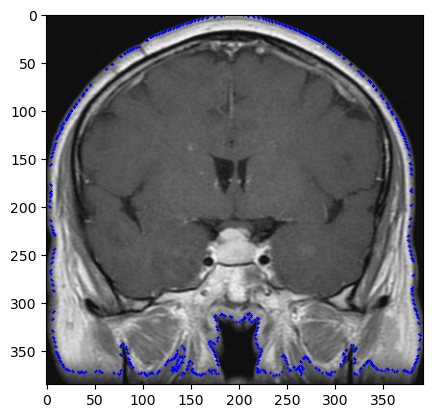

In [96]:
img = crop_img(file4)
plt.imshow(img)
plt.show()
image_process(img)
